In [10]:
from itertools import islice

import os
import numpy as np
import tensorflow as tf
import python_speech_features as psp
import IPython
from IPython.display import Audio, display
from scipy.io import wavfile

%matplotlib inline
import matplotlib.pyplot as plt

from features.wav_iterator import batcher, wav_iterator
from features.wav_iterator import lmf_iterator, stft_iterator
from features.spectral_features import stft, istft

audio_dir = os.environ['AUDIO_PATH']

In [11]:
sig_length = 200
# not sure how to calculate size of frequency representation in advance
stft_step = 256
stft_len = 512
freq_extent = stft_len // 2 + 1

wavs = wav_iterator(audio_dir, sig_length=sig_length*stft_step)
sb = stft_iterator(wavs, stft_len=stft_len, stft_step=stft_step, use_diffs=False, two_sided=False)

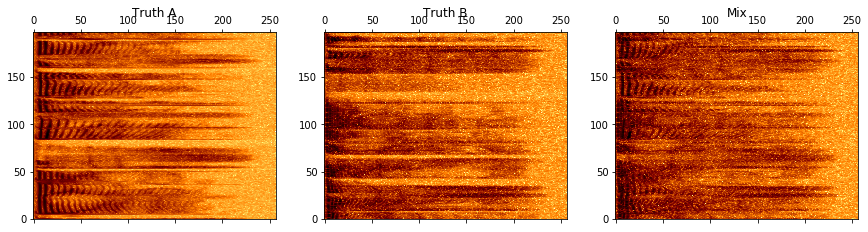

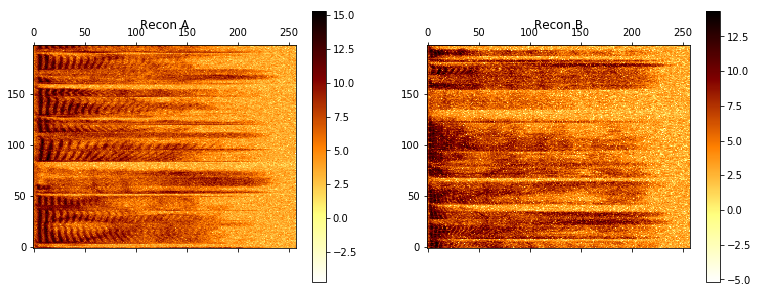

In [12]:
def plot_mix(src1, src2, mix, rot=False, cmap="afmhot_r"):
    """
    Plot original data
    """
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,4,1)
    if rot:
        org = 'bottom'
        src1 = src1.T
        src2 = src2.T
        mix = mix.T
    else:
        org = 'top'
    
    ax.set_title("Truth A")
    ax.matshow(src1, cmap=cmap, interpolation='none', origin = org)
    ax = plt.subplot(1,4,2)
    ax.set_title("Truth B")
    ax.matshow(src2, cmap=cmap, interpolation='none', origin = org)
    ax = plt.subplot(1,4,3)
    ax.set_title("Mix")
    ax.matshow(mix, cmap=cmap, interpolation='none', origin = org)


def plot_recons(src_recon1, src_recon2, rot=False, cmap="afmhot_r"):
    """
    Plot reconstructions
    """
    if rot:
        org = 'bottom'
        src_recon1 = src_recon1.T
        src_recon2 = src_recon2.T
    else:
        org = 'top'    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1,3,1)
    ax.set_title("Recon A")
    im = ax.matshow(src_recon1, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.5)
    ax = plt.subplot(1,3,2)
    ax.set_title("Recon B")
    im = ax.matshow(src_recon2, cmap=cmap, interpolation='none', origin = org)
    plt.colorbar(im, shrink=0.5)
    
    
for t, m in islice(sb,1):
    # Take log-magnitude spectrograms of truth signals and mix
    s1 = np.log(np.absolute(t[0])).real
    s2 = np.log(np.absolute(t[1].real))
    mix = np.log(np.absolute(m.real))
    plot_mix(s1, s2, mix, False)
    # Add random noise to TF representation
    s1_recon = s1+np.random.randn(*s1.shape)/2
    s2_recon = s2+np.random.randn(*s2.shape)/2
    plot_recons(s1_recon, s2_recon, False)
    # Play "reconstruction"
    # Will contain bloopy artifacts from noise insertion
    s1_recon_audio = istft(np.absolute(np.exp(s1_recon)) * np.exp(1j * np.angle(m)), fs=1, 
                           recon_size=sig_length*stft_step, hop=stft_step, two_sided=False)
    display(Audio(s1_recon_audio, rate=16000))
    
    plt.show()

In [4]:
(s1_recon * np.exp(1j * np.angle(m))).shape

(198, 513)

Implementation of the network

In [5]:
batch_size = 10
num_steps = sig_length - 2
input_shape = freq_extent
ff1_size = 80
recurrent_size = 50
ff2_size = 80

tf.reset_default_graph()
sess = tf.Session()
with sess.as_default():
    logmf_features = tf.placeholder(tf.float32, shape=(None, num_steps, input_shape), name="logmf_features")
    logmf_truth = tf.placeholder(tf.float32, shape=(None, 2, num_steps, input_shape), name="logmf_truth")
    ## Set up network
    # Feedforward 1
    feedforward_weights = tf.Variable(tf.random_normal((input_shape, ff1_size)), name="dense_wts_1")
    feedforward_bias = tf.Variable(tf.zeros((1, ff1_size)), name="dense_bias_1")
    # Recurrent layer
    recurrent_cell = tf.contrib.rnn.BasicRNNCell(recurrent_size)
    recurrent_state = recurrent_cell.zero_state(batch_size, logmf_features.dtype)
    # Feedforward 2
    feedforward_2_weights = tf.Variable(tf.random_normal((recurrent_size, ff2_size)), name="dense_wts_2")
    feedforward_2_bias = tf.Variable(tf.zeros((1, ff2_size)), name="dense_bias_2")
    # Preconstruction a (y_hat)
    precon_a_weights = tf.Variable(tf.random_normal((ff2_size, input_shape)), name="precon_a_wts")
    precon_a_bias = tf.Variable(tf.random_normal((1, input_shape)), name="precon_a_bias")
    # Preconstruction b
    precon_b_weights = tf.Variable(tf.random_normal((ff2_size, input_shape)), name="precon_b_wts")
    precon_b_bias = tf.Variable(tf.random_normal((1, input_shape)), name="precon_b_bias")
    # Mask
    mask_weights = tf.Variable(tf.random_normal((1,input_shape)), name="mask_wts")
    
    # Set up operations
    recons = {'a':[], 'b': []}
    for input_time in range(num_steps):
        if input_time > 0:
            tf.get_variable_scope().reuse_variables()
        # Feedforward 1 ops
        if input_time==0:
            print(logmf_features[:, input_time, :])
            print(feedforward_weights.value())

        feedforward_out = tf.matmul(logmf_features[:, input_time, :],feedforward_weights) + feedforward_bias
        feedforward_out = tf.nn.relu(feedforward_out)
        if input_time==0:
            print(feedforward_out)
        # Recurrent ops
        recurrent_output, recurrent_state = recurrent_cell(feedforward_out, recurrent_state)
        recurrent_output = tf.nn.relu(recurrent_output)
        if input_time<2:
            print(recurrent_output)
            print(recurrent_state)
        # Feedforward 2 ops
        feedforward_2_out = tf.matmul(recurrent_output,feedforward_2_weights) + feedforward_2_bias
        feedforward_2_out = tf.nn.relu(feedforward_2_out)
        if input_time==0:
            print(feedforward_2_out)
        # "Preconstruction" a/b
        precon_a = tf.matmul(feedforward_2_out,precon_a_weights) + precon_a_bias
        precon_b = tf.matmul(feedforward_2_out,precon_b_weights) + precon_b_bias
        if input_time==0:
            print("Preconstruction size")
            print(precon_a)
            print(precon_b)
        # Apply mask for final reconstruction
        recon_a = tf.multiply(precon_a / (precon_a+precon_b), mask_weights)
        recon_b = tf.multiply(precon_b / (precon_a+precon_b), mask_weights)
        recons['a'].append(recon_a)
        recons['b'].append(recon_b)
    out_a = tf.stack(recons['a'], axis=1)
    out_b = tf.stack(recons['b'], axis=1)
    out_pair = tf.stack((out_a,out_b), axis=1)
    print(out_pair)
    loss = tf.reduce_mean(tf.squared_difference(out_pair, logmf_truth))     

Tensor("strided_slice:0", shape=(?, 513), dtype=float32)
Tensor("dense_wts_1/read:0", shape=(513, 80), dtype=float32)
Tensor("Relu:0", shape=(?, 80), dtype=float32)
Tensor("Relu_1:0", shape=(10, 50), dtype=float32)
Tensor("basic_rnn_cell/Tanh:0", shape=(10, 50), dtype=float32)
Tensor("Relu_2:0", shape=(10, 80), dtype=float32)
Preconstruction size
Tensor("add_2:0", shape=(10, 513), dtype=float32)
Tensor("add_3:0", shape=(10, 513), dtype=float32)
Tensor("Relu_4:0", shape=(10, 50), dtype=float32)
Tensor("basic_rnn_cell_1/Tanh:0", shape=(10, 50), dtype=float32)
Tensor("stack_3:0", shape=(10, 2, 198, 513), dtype=float32)


In [6]:
input_shape

513

Feed-forward and loss calculation

KeyboardInterrupt: 

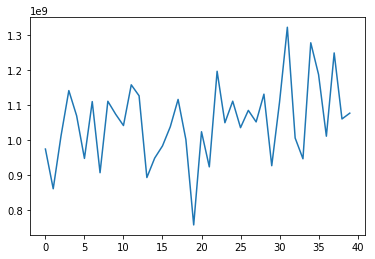

In [9]:
# Unending iterator
batches = batcher(sb, batch_size=batch_size)

# Optimization loop
with sess.as_default():
    tf.global_variables_initializer().run()
    optimizer = tf.train.GradientDescentOptimizer(0.001)
    descent_step = optimizer.minimize(loss)
    losses = []
    for truth, mix in islice(batches, 100):
        data = {logmf_features: mix,
                logmf_truth: truth}
        descent_step.run(feed_dict=data)        
        losses.append(loss.eval(feed_dict=data))
        if len(losses) % 10 == 0:
            IPython.display.clear_output(wait=True)
            plt.plot(range(len(losses)), losses)
            # pull out an example and plot it
            out_a_img = out_a[0].eval(feed_dict=data)
            out_b_img = out_b[0].eval(feed_dict=data)
            plot_mix(np.log(np.absolute(truth[0][0].real)), 
                     np.log(np.absolute(truth[0][1].real)), 
                     np.log(np.absolute(mix[0].real)))
            plot_recons(out_a_img.real, out_b_img.real)
            plt.show()
